In [1]:
import os
import random

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from einops import rearrange
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tf_layers
from tensorflow.keras.datasets.fashion_mnist import load_data as load_data_Fashion_MNIST
from tensorflow.keras.datasets.cifar10 import load_data as load_data_CIFAR_10

import nn
import nn.layers
import nn.activations
import nn.losses
import nn.network

In [2]:
%load_ext autoreload

In [12]:
%autoreload

## Utility functions

In [3]:
def print_sizes(dataset):
    for subset in ['train', 'test']:
        for part in ['x', 'y']:
            print(f'{subset:>5} {part} - {dataset[subset][part].shape}')

In [4]:
def plot_random_images(images):
    chosen_images = random.choices(images, k=16)
    joined_image = rearrange(chosen_images, '(nh nw) h w c -> (nh h) (nw w) c', nw=4)
    cmap = 'gray' if images.shape[-1] == 1 else None
    plt.imshow(joined_image, cmap=cmap)

## Fashion MNIST

### Loading data

In [5]:
(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = load_data_Fashion_MNIST()

fmnist = {
    'train': {
        'x': x_train_fmnist[..., np.newaxis] / 255.0,
        'y': y_train_fmnist,
        'y_hot': np.array(tf.one_hot(y_train_fmnist, 10))
    },
    'test': {
        'x': x_test_fmnist[..., np.newaxis] / 255.0,
        'y': y_test_fmnist,
        'y_hot': np.array(tf.one_hot(y_test_fmnist, 10))
    }
}

In [ ]:
print_sizes(fmnist)

In [ ]:
plot_random_images(fmnist['train']['x'])

### Tensorflow

In [ ]:
tf_model_fmnist = keras.models.Sequential([
    tf_layers.InputLayer((28, 28, 1)),
    tf_layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf_layers.Flatten(),
    tf_layers.Dense(512, activation='relu'),
    tf_layers.Dropout(0.5),
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dropout(0.5),
    tf_layers.Dense(10 , activation = 'softmax')
])

tf_model_fmnist.summary()

In [ ]:
tf_model_fmnist.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
history = tf_model_fmnist.fit(
    fmnist['train']['x'],
    fmnist['train']['y_hot'],
    validation_data=(fmnist['test']['x'], fmnist['test']['y_hot']),
    epochs=25,
    batch_size=64,
)

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = tf_model_fmnist.predict(fmnist['test']['x'])
true_classes = fmnist['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

### This library

In [ ]:
%autoreload

In [ ]:
layers = [
    nn.layers.InputLayer((28, 28, 1)),
    nn.layers.Padding2DLayer('zeros', (1, 1)),
    nn.layers.Conv2DLayer(8, kernel_size=(3, 3), stride=(1, 1)),
    nn.layers.FlattenLayer(),
    nn.layers.DropoutLayer(0.5),
    nn.layers.DenseLayer(100, initializer=nn.initializers.GlorotUniformInitialization()),
    nn.layers.BiasLayer(),
    nn.layers.ActivationLayer(nn.activations.ReLuActivation()),
    nn.layers.DropoutLayer(0.5),
    nn.layers.DenseLayer(10, initializer=nn.initializers.GlorotUniformInitialization()),
    nn.layers.BiasLayer(),
    nn.layers.ActivationLayer(nn.activations.ReLuActivation()),
]

own_model_fmnist = nn.network.NeuralNetwork(layers, nn.losses.MseLoss())
own_model_fmnist.summary()

In [ ]:
own_model_fmnist.fit(fmnist['train']['x']-0.5, fmnist['train']['y_hot'], learning_rate=0.001, epochs=2)

In [ ]:
predictions = own_model_fmnist.predict(fmnist['test']['x']-0.5)
true_classes = fmnist['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes, zero_division=0)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

## CIFAR 10

### Loading data

In [ ]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = load_data_CIFAR_10()

y_train_cifar10 = y_train_cifar10.flatten()
y_test_cifar10 = y_test_cifar10.flatten()

cifar10 = {
    'train': {
        'x': x_train_cifar10 / 255,
        'y': y_train_cifar10,
        'y_hot': np.array(tf.one_hot(y_train_cifar10, 10))
    },
    'test': {
        'x': x_test_cifar10 / 255,
        'y': y_test_cifar10,
        'y_hot': np.array(tf.one_hot(y_test_cifar10, 10))
    }
}

In [ ]:
print_sizes(cifar10)

In [ ]:
plot_random_images(cifar10['train']['x'])

### Tensorflow

In [ ]:
tf_model_cifar10 = keras.models.Sequential([
    tf_layers.InputLayer((32, 32, 3)),
    tf_layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Flatten(),
    tf_layers.Dense(512, activation='relu'),
    tf_layers.Dropout(0.5),
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dropout(0.5),
    tf_layers.Dense(10 , activation = 'softmax')
])

tf_model_cifar10.summary()

In [ ]:
tf_model_cifar10.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
history = tf_model_cifar10.fit(
    cifar10['train']['x'],
    cifar10['train']['y_hot'],
    validation_data=(cifar10['test']['x'], cifar10['test']['y_hot']),
    epochs=15,
    batch_size=64,
)

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = tf_model_cifar10.predict(cifar10['test']['x'])
true_classes = cifar10['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

### This library

## 20 class dataset

### Loading data

In [ ]:
# https://www.kaggle.com/datasets/boulahchichenadir/algerian-used-cars

ds = tf.keras.utils.image_dataset_from_directory(
    'data/cars',
    color_mode='rgb',
    label_mode='int',
    shuffle=True,
    seed=42,
    image_size=(64, 64),
)

x_cars, y_cars = zip(*ds)
x_cars = np.concatenate(x_cars).astype(int) / 255
y_cars = np.concatenate(y_cars)

x_train_cars, x_test_cars, y_train_cars, y_test_cars = train_test_split(
    x_cars,
    y_cars,
    test_size=0.20,
    random_state=42
)

cars = {
    'train': {
        'x': x_train_cars,
        'y': y_train_cars,
        'y_hot': np.array(tf.one_hot(y_train_cars, 20))
    },
    'test': {
        'x': x_test_cars,
        'y': y_test_cars,
        'y_hot': np.array(tf.one_hot(y_test_cars, 20))
    }
}

In [ ]:
print_sizes(cars)

In [ ]:
plot_random_images(cars['train']['x'])

### Tensorflow

In [ ]:
tf_model_cars = keras.models.Sequential([
    tf_layers.InputLayer((64,64,3)),
    tf_layers.Conv2D(16, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(32, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(64, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(128, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Flatten(),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(20 , activation = 'softmax')
])

tf_model_cars.summary()

In [ ]:
tf_model_cars.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
history = tf_model_cars.fit(
    cars['train']['x'],
    cars['train']['y_hot'],
    validation_data=(cars['test']['x'], cars['test']['y_hot']),
    epochs=40,
    batch_size=64,
)

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = tf_model_cars.predict(cars['test']['x'])
true_classes = cars['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

In [ ]:
history = tf_model_cifar10.fit(
    cifar10['train']['x'],
    cifar10['train']['y_hot'],
    validation_data=(cifar10['test']['x'], cifar10['test']['y_hot']),
    epochs=15,
    batch_size=64,
)

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = tf_model_cifar10.predict(cifar10['test']['x'])
true_classes = cifar10['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

### This library

## 20 class dataset

### Loading data

In [ ]:
# https://www.kaggle.com/datasets/boulahchichenadir/algerian-used-cars

ds = tf.keras.utils.image_dataset_from_directory(
    'data/cars',
    color_mode='rgb',
    label_mode='int',
    shuffle=True,
    seed=42,
    image_size=(64, 64),
)

x_cars, y_cars = zip(*ds)
x_cars = np.concatenate(x_cars).astype(int) / 255
y_cars = np.concatenate(y_cars)

x_train_cars, x_test_cars, y_train_cars, y_test_cars = train_test_split(
    x_cars,
    y_cars,
    test_size=0.20,
    random_state=42
)

cars = {
    'train': {
        'x': x_train_cars,
        'y': y_train_cars,
        'y_hot': np.array(tf.one_hot(y_train_cars, 20))
    },
    'test': {
        'x': x_test_cars,
        'y': y_test_cars,
        'y_hot': np.array(tf.one_hot(y_test_cars, 20))
    }
}

In [ ]:
print_sizes(cars)

In [ ]:
plot_random_images(cars['train']['x'])

### Tensorflow

In [ ]:
tf_model_cars = keras.models.Sequential([
    tf_layers.InputLayer((64,64,3)),
    tf_layers.Conv2D(16, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(32, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(64, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(128, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Flatten(),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(20 , activation = 'softmax')
])

tf_model_cars.summary()

In [ ]:
tf_model_cars.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
history = tf_model_cars.fit(
    cars['train']['x'],
    cars['train']['y_hot'],
    validation_data=(cars['test']['x'], cars['test']['y_hot']),
    epochs=40,
    batch_size=64,
)

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = tf_model_cars.predict(cars['test']['x'])
true_classes = cars['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = tf_model_cifar10.predict(cifar10['test']['x'])
true_classes = cifar10['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

### This library

## 20 class dataset

### Loading data

In [ ]:
# https://www.kaggle.com/datasets/boulahchichenadir/algerian-used-cars

ds = tf.keras.utils.image_dataset_from_directory(
    'data/cars',
    color_mode='rgb',
    label_mode='int',
    shuffle=True,
    seed=42,
    image_size=(64, 64),
)

x_cars, y_cars = zip(*ds)
x_cars = np.concatenate(x_cars).astype(int) / 255
y_cars = np.concatenate(y_cars)

x_train_cars, x_test_cars, y_train_cars, y_test_cars = train_test_split(
    x_cars,
    y_cars,
    test_size=0.20,
    random_state=42
)

cars = {
    'train': {
        'x': x_train_cars,
        'y': y_train_cars,
        'y_hot': np.array(tf.one_hot(y_train_cars, 20))
    },
    'test': {
        'x': x_test_cars,
        'y': y_test_cars,
        'y_hot': np.array(tf.one_hot(y_test_cars, 20))
    }
}

In [ ]:
print_sizes(cars)

In [ ]:
plot_random_images(cars['train']['x'])

### Tensorflow

In [ ]:
tf_model_cars = keras.models.Sequential([
    tf_layers.InputLayer((64,64,3)),
    tf_layers.Conv2D(16, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(32, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(64, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(128, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Flatten(),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(20 , activation = 'softmax')
])

tf_model_cars.summary()

In [ ]:
tf_model_cars.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
history = tf_model_cars.fit(
    cars['train']['x'],
    cars['train']['y_hot'],
    validation_data=(cars['test']['x'], cars['test']['y_hot']),
    epochs=40,
    batch_size=64,
)

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = tf_model_cars.predict(cars['test']['x'])
true_classes = cars['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

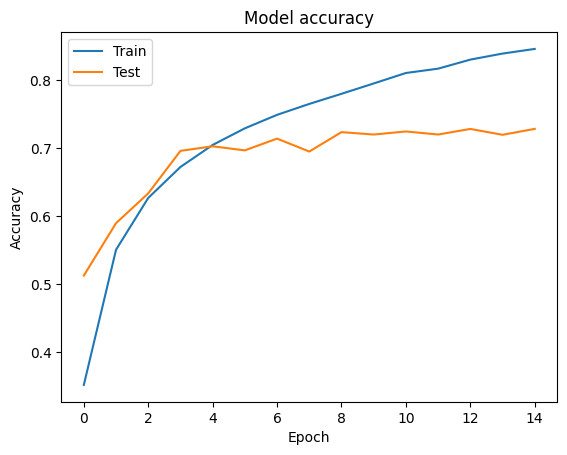

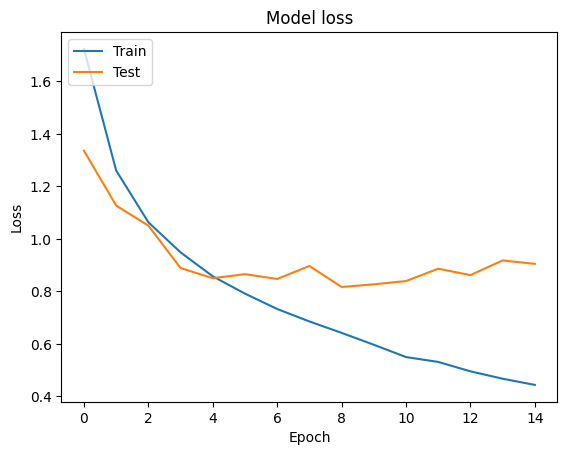

In [72]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

313/313 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1000
           1       0.88      0.84      0.86      1000
           2       0.71      0.58      0.64      1000
           3       0.52      0.51      0.52      1000
           4       0.60      0.74      0.66      1000
           5       0.69      0.56      0.62      1000
           6       0.83      0.75      0.79      1000
           7       0.71      0.82      0.76      1000
           8       0.79      0.87      0.82      1000
           9       0.80      0.85      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



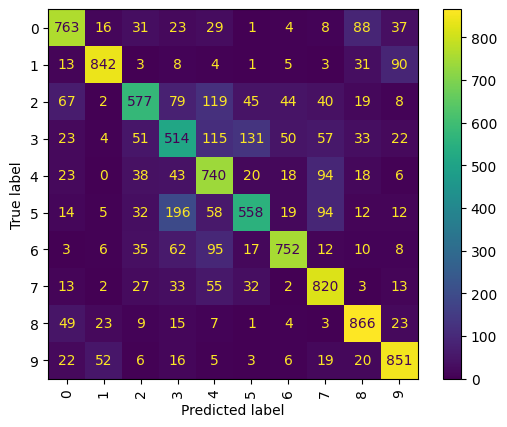

In [74]:
predictions = tf_model_cifar10.predict(cifar10['test']['x'])
true_classes = cifar10['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

### This library

## 20 class dataset

### Loading data

In [28]:
# https://www.kaggle.com/datasets/boulahchichenadir/algerian-used-cars

ds = tf.keras.utils.image_dataset_from_directory(
    'data/cars',
    color_mode='rgb',
    label_mode='int',
    shuffle=True,
    seed=42,
    image_size=(64, 64),
)

x_cars, y_cars = zip(*ds)
x_cars = np.concatenate(x_cars).astype(int) / 255
y_cars = np.concatenate(y_cars)

x_train_cars, x_test_cars, y_train_cars, y_test_cars = train_test_split(
    x_cars,
    y_cars,
    test_size=0.20,
    random_state=42
)

cars = {
    'train': {
        'x': x_train_cars,
        'y': y_train_cars,
        'y_hot': np.array(tf.one_hot(y_train_cars, 20))
    },
    'test': {
        'x': x_test_cars,
        'y': y_test_cars,
        'y_hot': np.array(tf.one_hot(y_test_cars, 20))
    }
}

Found 3235 files belonging to 20 classes.


In [78]:
print_sizes(cars)

train x - (2588, 64, 64, 3)
train y - (2588,)
 test x - (647, 64, 64, 3)
 test y - (647,)


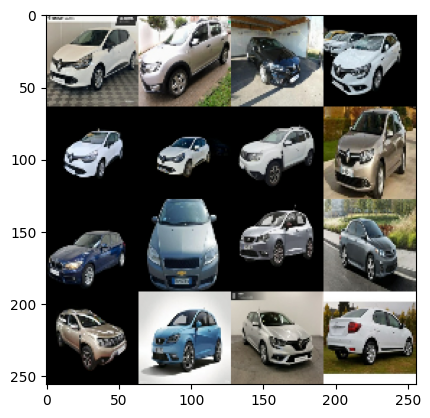

In [79]:
plot_random_images(cars['train']['x'])

### Tensorflow

In [80]:
tf_model_cars = keras.models.Sequential([
    tf_layers.InputLayer((64,64,3)),
    tf_layers.Conv2D(16, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(32, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(64, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(128, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Flatten(),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(20 , activation = 'softmax')
])

tf_model_cars.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 6, 6, 64)       

In [81]:
tf_model_cars.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [85]:
history = tf_model_cars.fit(
    cars['train']['x'],
    cars['train']['y_hot'],
    validation_data=(cars['test']['x'], cars['test']['y_hot']),
    epochs=40,
    batch_size=64,
)

Epoch 1/40
41/41 [==============================] - 1s 9ms/step - loss: 0.5807 - categorical_accuracy: 0.8138 - val_loss: 1.1978 - val_categorical_accuracy: 0.6832
Epoch 2/40
41/41 [==============================] - 0s 9ms/step - loss: 0.4915 - categorical_accuracy: 0.8501 - val_loss: 1.1364 - val_categorical_accuracy: 0.7156
Epoch 3/40
41/41 [==============================] - 0s 9ms/step - loss: 0.3946 - categorical_accuracy: 0.8783 - val_loss: 1.2036 - val_categorical_accuracy: 0.7063
Epoch 4/40
41/41 [==============================] - 0s 9ms/step - loss: 0.3828 - categorical_accuracy: 0.8818 - val_loss: 1.0767 - val_categorical_accuracy: 0.7465
Epoch 5/40
41/41 [==============================] - 0s 8ms/step - loss: 0.3346 - categorical_accuracy: 0.8930 - val_loss: 1.0811 - val_categorical_accuracy: 0.7403
Epoch 6/40
41/41 [==============================] - 0s 8ms/step - loss: 0.2526 - categorical_accuracy: 0.9189 - val_loss: 1.1228 - val_categorical_accuracy: 0.7481
Epoch 7/40
41/41

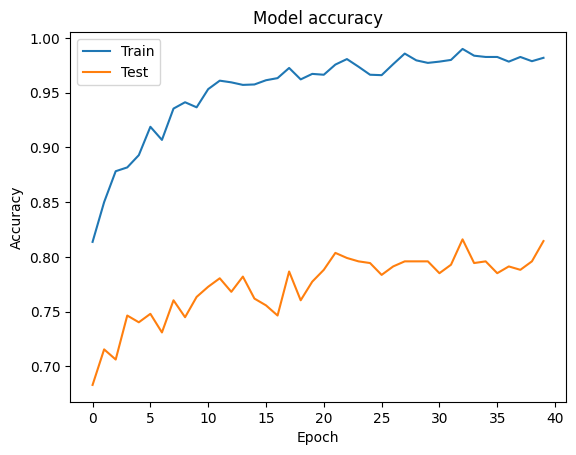

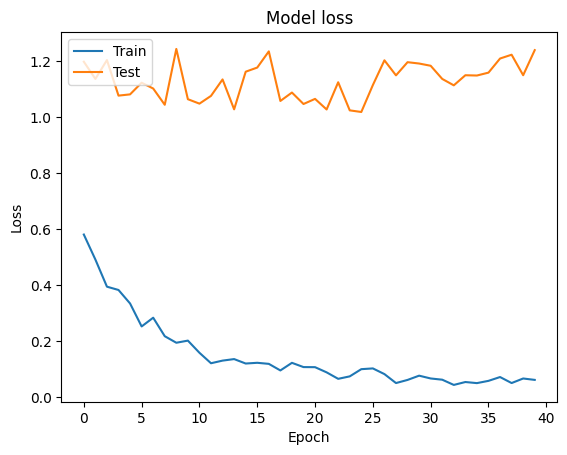

In [86]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

21/21 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.65      0.76      0.70        29
           1       1.00      0.55      0.71        20
           2       0.81      0.88      0.85        25
           3       0.89      0.97      0.93        32
           4       0.84      0.92      0.88        66
           5       0.88      0.85      0.87        54
           6       0.88      0.78      0.82        27
           7       0.95      0.67      0.78        27
           8       0.86      1.00      0.93        32
           9       0.66      0.90      0.76        51
          10       0.89      1.00      0.94         8
          11       1.00      1.00      1.00        13
          12       0.89      0.71      0.79        35
          13       0.85      0.73      0.79        30
          14       0.75      0.55      0.63        33
          15       0.84      0.84      0.84        56
          16       0.71     

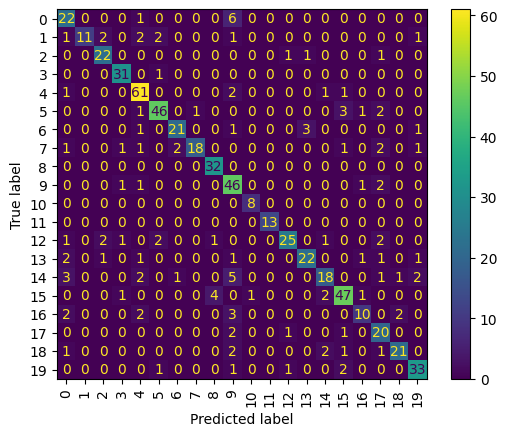

In [88]:
predictions = tf_model_cars.predict(cars['test']['x'])
true_classes = cars['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

### This library